In [2]:
#pip install ip2geotools
#pip install ipinfo
#conda install -c anaconda basemap

In [3]:

import pandas as pd 
#import data from csv

dfs = []
for port in list(range(12000,12050)):
    file="~/.topaz/crawler"+str(port)+".csv"
    df = pd.read_csv(file) 
    df.drop(columns=['index'])
    dfs.append(df)
df_all_with_dups = pd.concat(dfs).reset_index(drop=True).sort_values(by=['seq_no'], ascending=False) #ensure we keep highest seq no
df_all = df_all_with_dups.drop_duplicates(subset="node_id", keep = 'first').reset_index(drop=True)
df_all.set_index('node_id')
df = df_all[df_all['fork_digest']=='f071c66c']

len(df_all),len(df)

(418, 375)

In [4]:
df_all[df_all['ip4']=='18.194.126.78']

,index,timestamp,node_id,peer_id,ip4,tcp4,udp4,ip6,tcp6,udp6,fork_digest,seq_no,subnet_ids,enr
394,39,2020-05-15][17:44:54,02daa24c13fd5e4dbdbba9bc866b38e182cfbc0e16f4de...,16Uiu2HAm5kiFiJjdoKniqT5bYsD9ptHv1cdBMrhSYSLoM...,18.194.126.78,9000.0,9000,NaN,NaN,NaN,9925efd6,1,[],enr:-LK4QOmIS-qkKAKueA6JVuCrNEloBLg8SEZusrR0Dv...


In [5]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt


fork_digests = df_all["fork_digest"].to_list()

counts = Counter(fork_digests)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(12,6))
plt.title('Fork Digest by Node Count')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()


<Figure size 1200x600 with 1 Axes>

In [6]:
from collections import Counter 
node_ids = df["node_id"].to_list()
node_ids = [node_id.strip() for node_id in node_ids]
node_ids_freq = [Counter(node_id) for node_id in node_ids]
hex_chars = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
freqs = []
for node_id_freq in node_ids_freq:
    freqs.append([node_id_freq[hex_char] for hex_char in hex_chars])
    


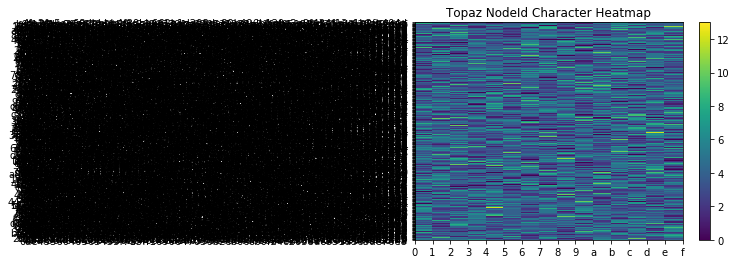

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.meshgrid(hex_chars, node_ids)
intensity = np.array(freqs)


plt.title('Topaz NodeId Character Heatmap')
plt.rcParams["figure.figsize"] = (50,50)
plt.pcolormesh(x, y, intensity)
plt.colorbar()
plt.show()

In [8]:
import string
from collections import Counter 

peer_ids = df["peer_id"].to_list()

peer_ids_freq = [Counter(peer_id) for peer_id in peer_ids]
ascii_chars = [char for char in string.ascii_letters] + ['0','1','2','3','4','5','6','7','8','9']
freqs = []
for peer_id_freq in peer_ids_freq:
    freqs.append([peer_id_freq[char] for char in ascii_chars])

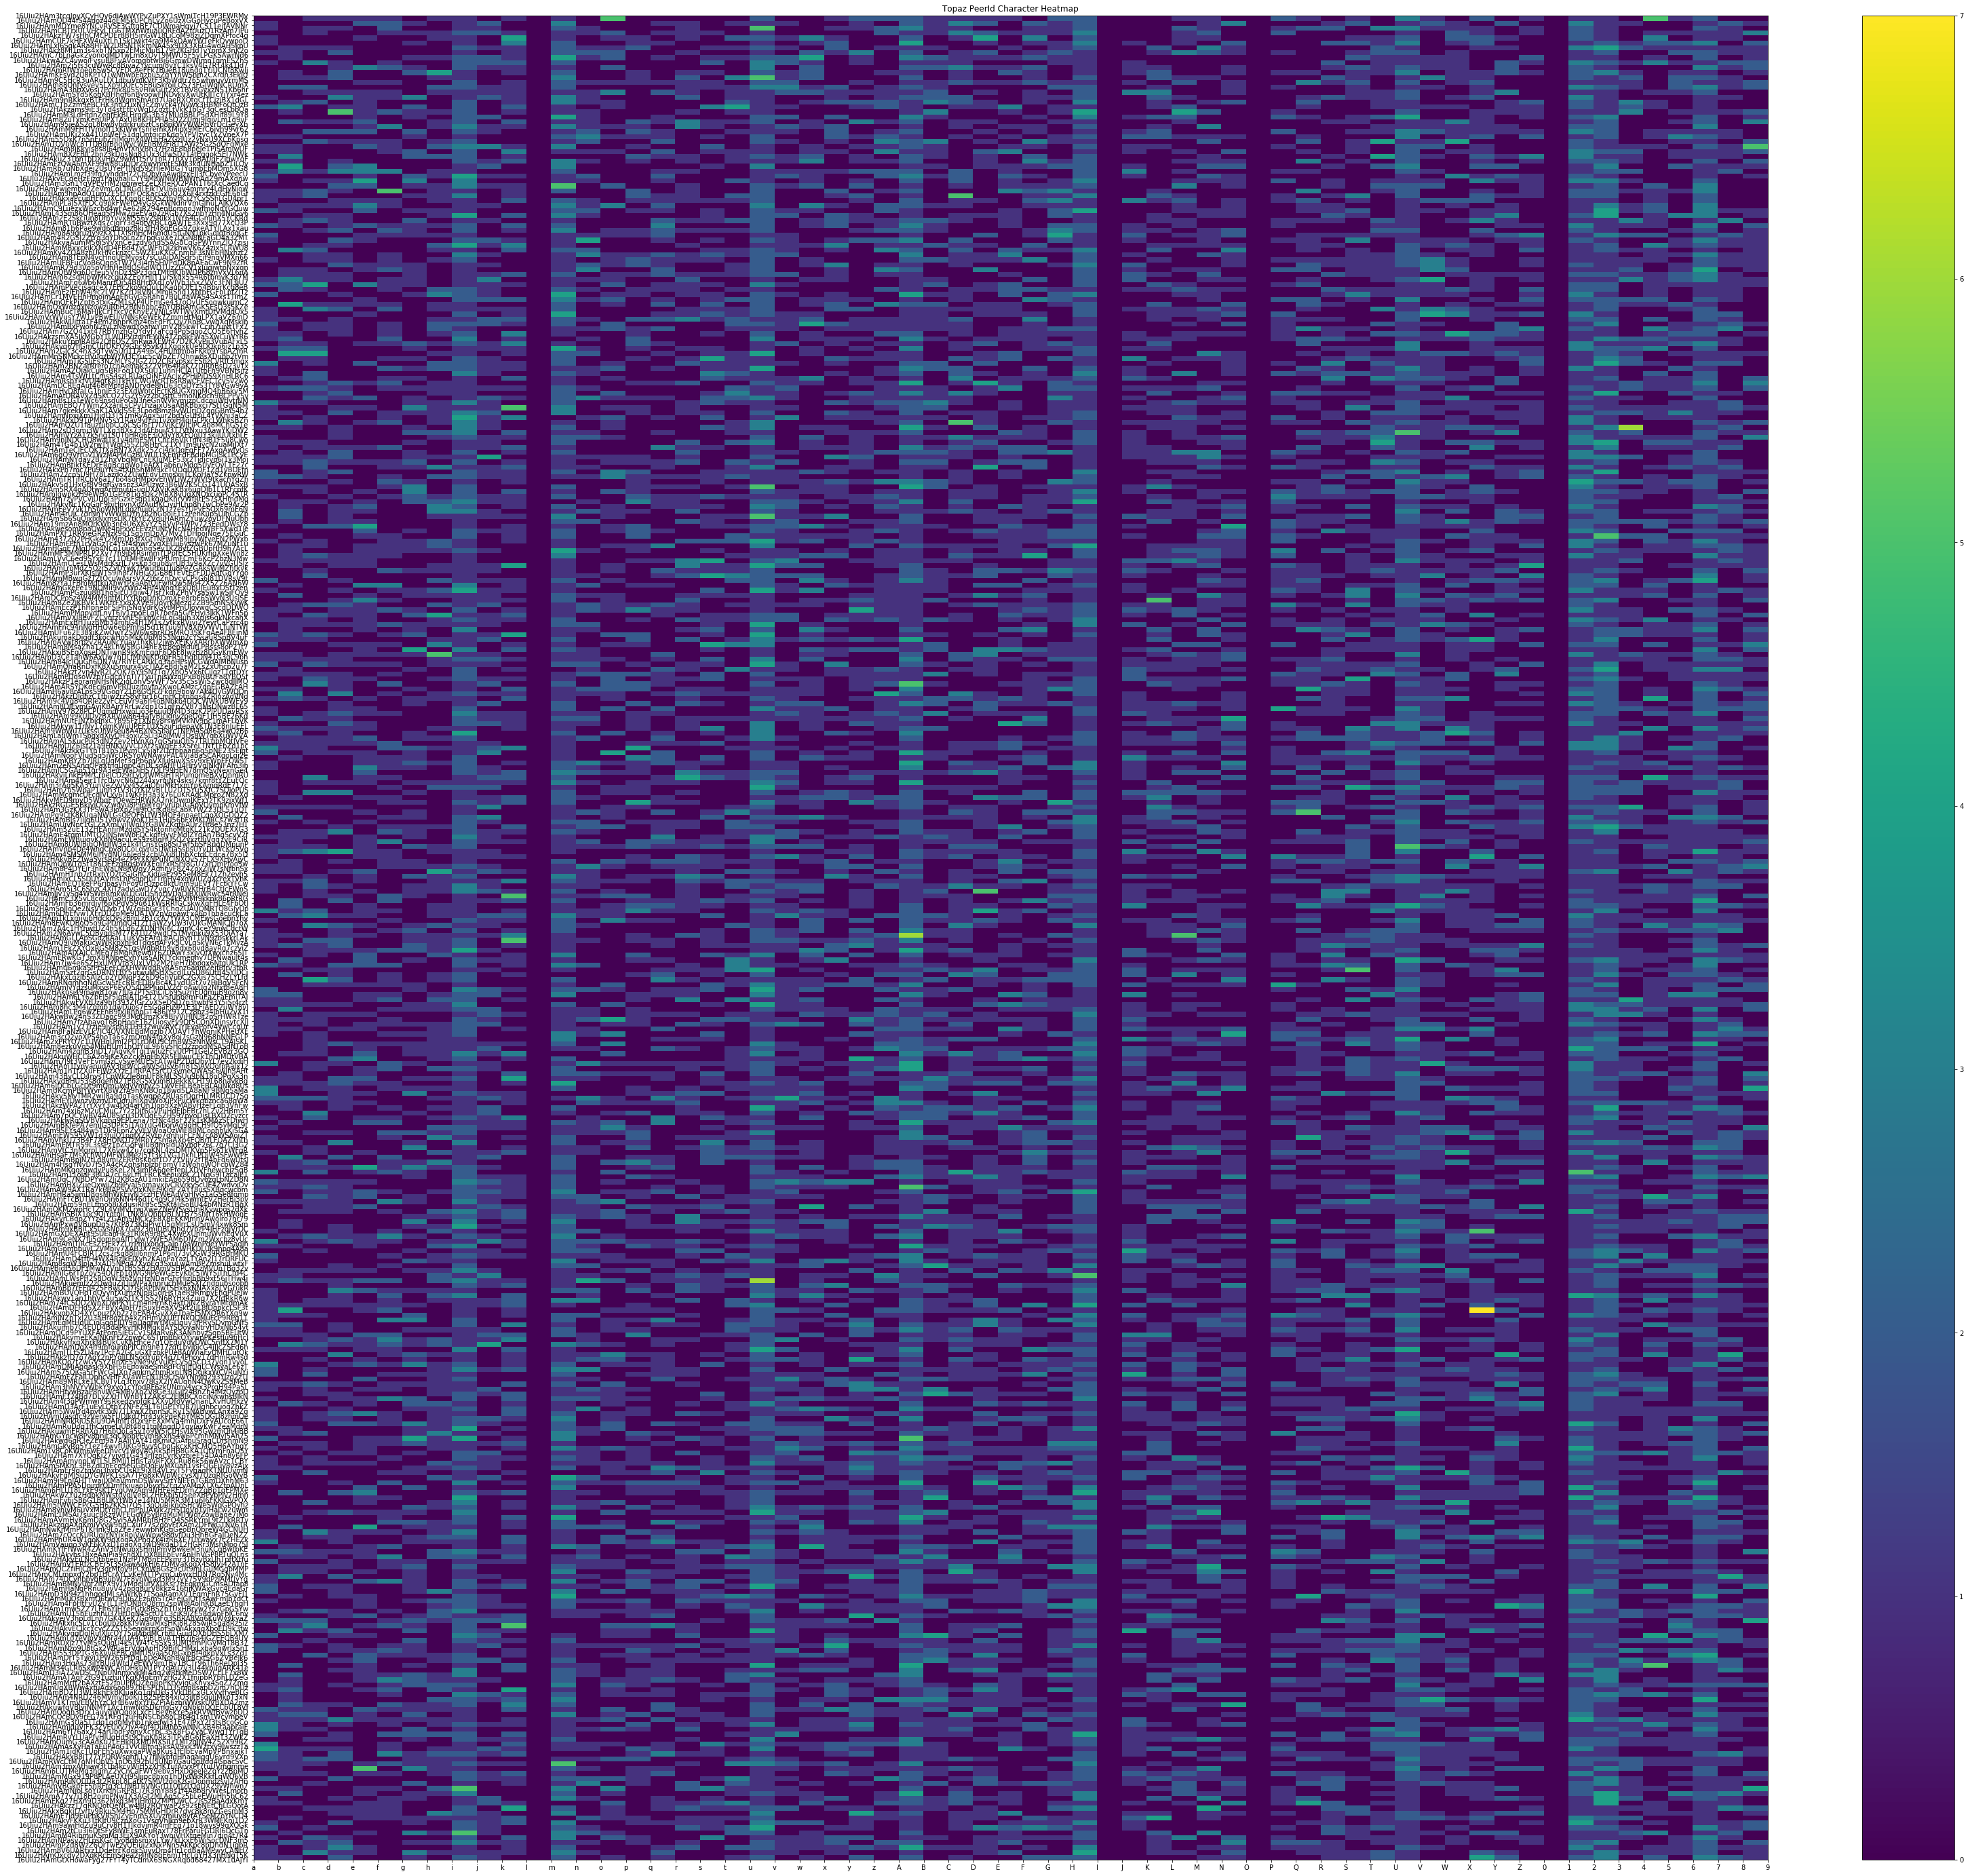

In [9]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.meshgrid(ascii_chars, peer_ids)
intensity = np.array(freqs)


plt.title('Topaz PeerId Character Heatmap')
plt.rcParams["figure.figsize"] = (50,50)
plt.pcolormesh(x, y, intensity)
plt.colorbar() 
plt.show() 

In [10]:
#from ip2geotools.databases.noncommercial import DbIpCity
#from ip2geotools.databases.noncommercial import Ipstack
#from ipaddress import ip_address

#ips = df["ip4"].to_list()
#bad_ips=["34.87.177.140","68.183.226.13","128.199.150.25","172.104.55.198"]
#ips = list(set(ips)-set(bad_ips))
#filtered_ips=[]
#for ip in ips:
#  a = ip_address(ip)
#  if not a.is_private:
#    filtered_ips.append(ip)
    
#ips_info_ip_city = [DbIpCity.get(ip, api_key='free') for ip in filtered_ips]
#ips_info = [Ipstack.get(ip, api_key='') for ip in filtered_ips]
#ips_info=[]
#for ip in filtered_ips:
#    print(ip)
#    ips_info.append(DbIpCity.get(ip, api_key='free'))

#import pickle

#file = open('/Users/jonny/.imp/ips_info.pkl', 'rb')
#saved_ips_info = pickle.load(file)
#file.close()



In [11]:
import ipinfo
import pickle

ips = df["ip4"].to_list()

# load any stored ip info
file = open('/Users/jonny/.topaz/ips_info.pkl', 'rb')
saved_ips_info = pickle.load(file)
file.close()

# determine what ips we need to lookup
need_info = []
for ip in ips:
    if ip not in saved_ips_info:
        need_info.append(ip)
        
print("Fetching missing info for ", len(need_info), " ip addresses.");
        
# get missing ip info
handler = ipinfo.getHandler('7bbf8b616179fb')
ips_info = [handler.getDetails(ip) for ip in need_info]

# save the ip info for next time

file = open('/Users/jonny/.topaz/ips_info.pkl', 'wb')

for ip_info in ips_info:
    saved_ips_info[ip_info.ip] = ip_info.all

pickle.dump(saved_ips_info,file)
file.close()


Fetching missing info for  89  ip addresses.


In [12]:
ips_info={}
for ip in ips:
    ips_info[ip]=saved_ips_info[ip]




In [13]:
#WHOIS
# whois -h whois.cymru.com " -v 62.210.170.177"
#  whois -h whois.arin.net 159.65.217.119
# whois -h whois.ripe.net 62.210.170.177
bad_ips = []
for ip,info in ips_info.items():
    if info['country_name'] == None:
        bad_ips.append(ip)
        
pd.set_option('max_colwidth', 100)
#pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 200)
#pd.reset_option('max_colwidth')
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.expand_frame_repr',False)

# collect node_ids of the records with bad ip addresses
bad_ip_node_ids = df[df['ip4'].isin(bad_ips)]['node_id'].to_list()
df_all_with_dups[df_all_with_dups['node_id'].isin(bad_ip_node_ids)]

,index,timestamp,node_id,peer_id,ip4,tcp4,udp4,ip6,tcp6,udp6,fork_digest,seq_no,subnet_ids,enr
3830,23,2020-05-15][17:44:52,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
921,41,2020-05-15][17:44:55,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
4230,64,2020-05-15][17:44:56,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
2792,63,2020-05-15][17:44:48,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
2595,43,2020-05-15][17:44:55,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
3401,48,2020-05-15][17:44:55,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
291,25,2020-05-15][17:44:55,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
1927,5,2020-05-15][17:44:51,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
3779,63,2020-05-15][17:44:52,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...
3460,17,2020-05-15][17:44:55,c57ead94d20fc5e5bfcaa7116c9f00f56c79ac3a8bd7f2b7c3125e1c30cc2507,16Uiu2HAmP2d8WzZ6QrTwEzvQEiuj2xNxPNn5AkKpc8bDhdN1igbR,172.17.0.2,13000.0,12000,NaN,NaN,NaN,f071c66c,6657,"[2, 5]",enr:-LS4QHeLG5e2zZy7tB-def4uQBilTt8qIuAoUZO6Ne_uX_kEQg2vIgyHaBn0UrEws6SzFqwaPMDG84xiWrEnSyZzWQmC...


In [14]:
# num nodes with bad ip addresses
len(df_all_with_dups[df_all_with_dups['node_id'].isin(bad_ip_node_ids)].drop_duplicates(subset="node_id", keep = 'first'))

11

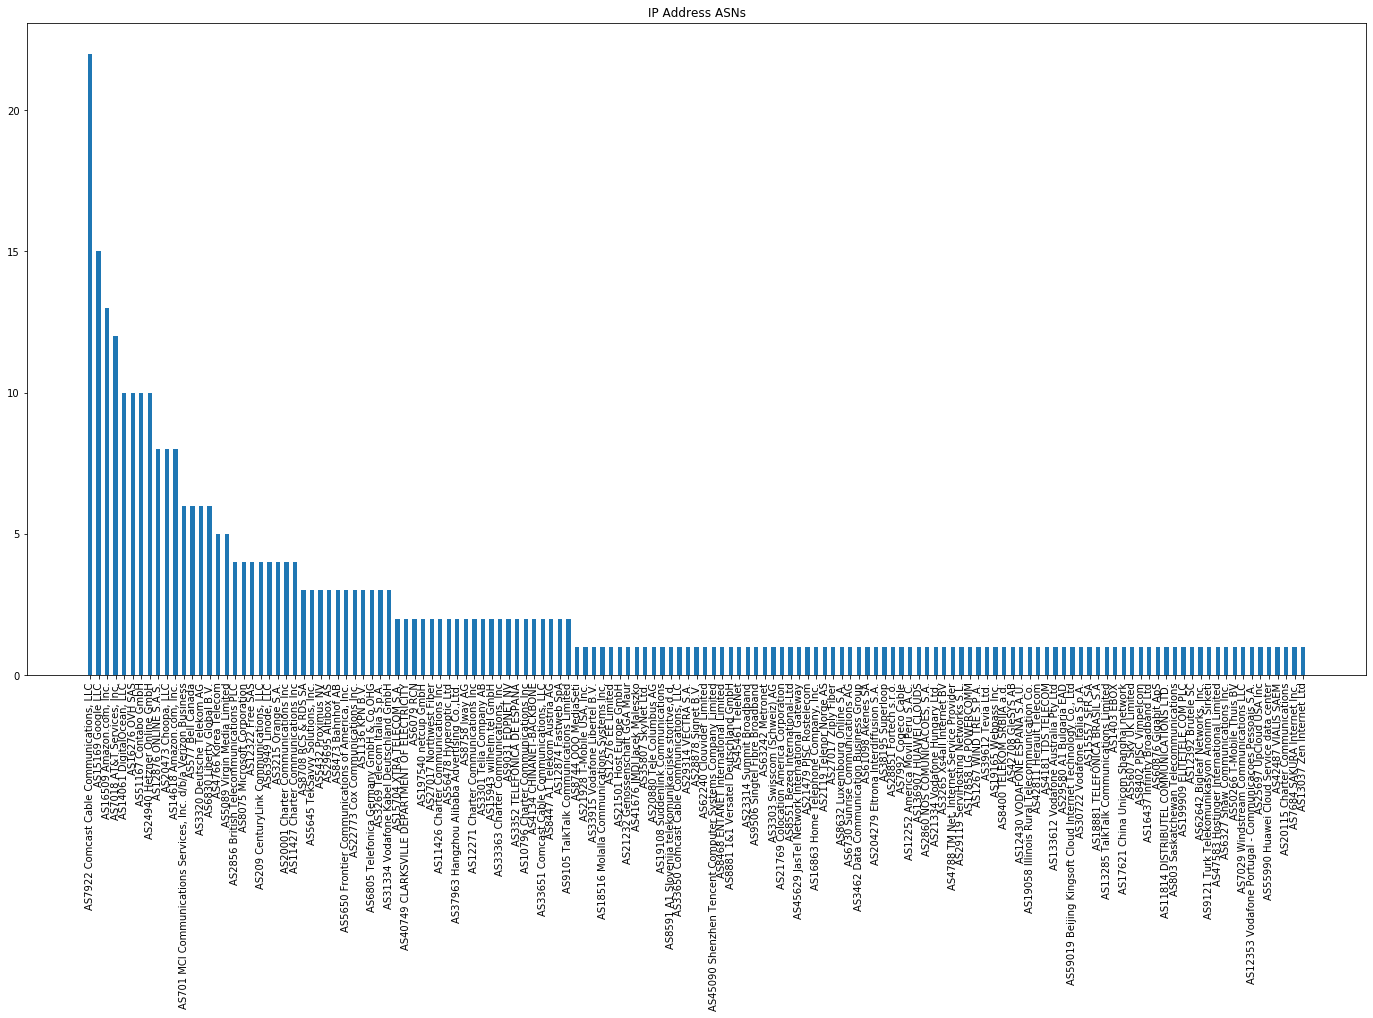

In [15]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

asns=[]

for ip,info in ips_info.items():
    if info['country_name'] != None:
        asns.append(info['org'])

        
counts = Counter(asns)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(24,12))
plt.title('IP Address ASNs')
plt.bar(indexes, values, width)
plt.xticks(rotation=90)
plt.xticks(indexes, labels)
plt.show()




In [16]:
sum(values)


353

In [17]:
#asn_info={}
#temp={}
#for ip, info in saved_ips_info.items():
#    #print(ip)
#    if 'org' in info:
#        org = info['org']
#        if org not in temp:
#            whois_raw_text = !whois -h whois.cymru.com "{ip}"    
#            whois_results = whois_raw_text[1].split('|')
#            asn = whois_results[0].strip()
#            asn_name = whois_results[2].strip()
#            if asn in asn_info:
#                print(ip)
#                print("Trying to add (",asn,",",asn_name, "), but it already exists!")
#                print("(",asn,",",asn_info[asn], ") previously inserted!")
#                print(info)
#            asn_info[asn]=asn_name
#            #print("Added ",foo[2].strip())
#            temp[org] = True
#            #print("TEMP Added ",org)
        
    


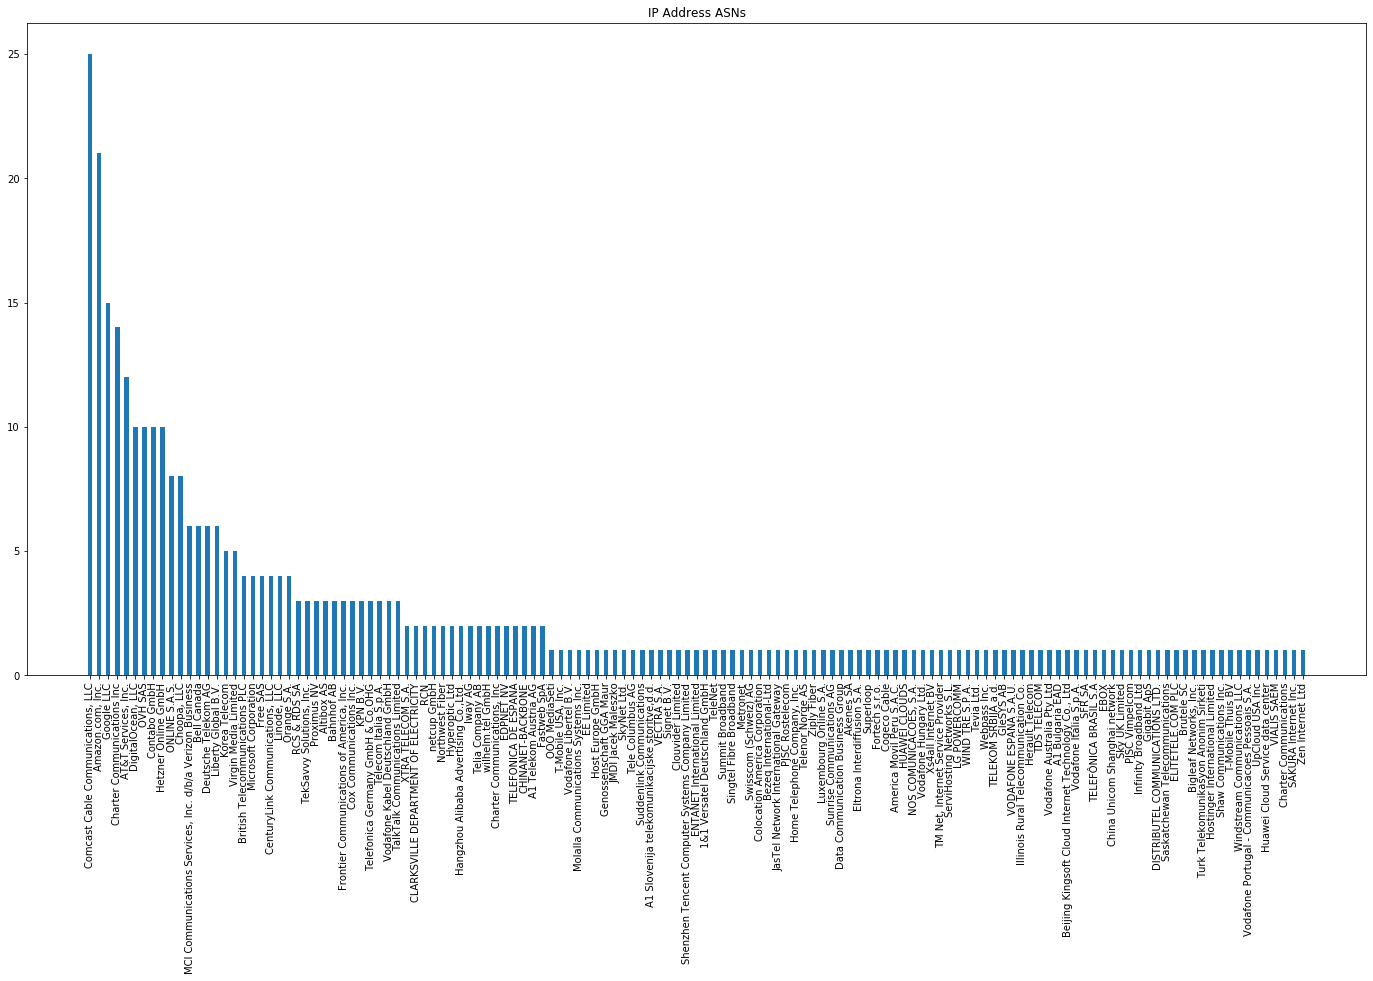

In [18]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

asn_orgs = [info['org'] if 'org' in info else 'None' for ip,info in ips_info.items()]
asn_orgs = [' '.join(org.split(' ')[1:]) for org in asn_orgs if org != 'None']

        
counts = Counter(asn_orgs)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(24,12))
plt.title('IP Address ASNs')
plt.bar(indexes, values, width)
plt.xticks(rotation=90)
plt.xticks(indexes, labels)
plt.show()


/Users/jonny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


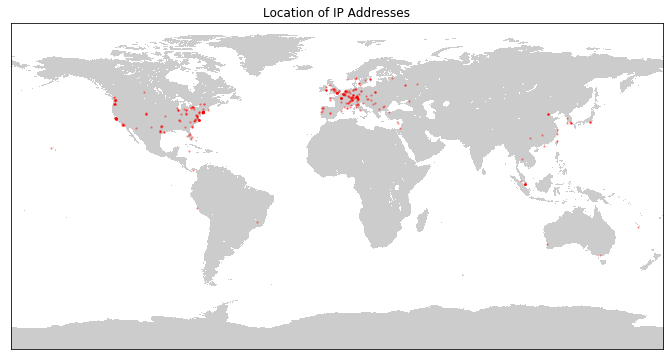

In [19]:
import os
os.environ['PROJ_LIB'] = '/Users/jonny/opt/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lats=[]
lons=[]
for ip,info in ips_info.items():
    if info['country_name'] != None:
        lats.append(float(info['latitude']))
        lons.append(float(info['longitude']))


plt.figure(figsize=(12,6))
map = Basemap(projection='cyl', resolution='l')
#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='#cc9955', lake_color='aqua')
#map.bluemarble()
map.drawlsmask()

x, y = map(lons, lats)
map.scatter(x, y, s=2, color='#ff0000', marker='o', alpha=0.3)
plt.title('Location of IP Addresses')
plt.show()

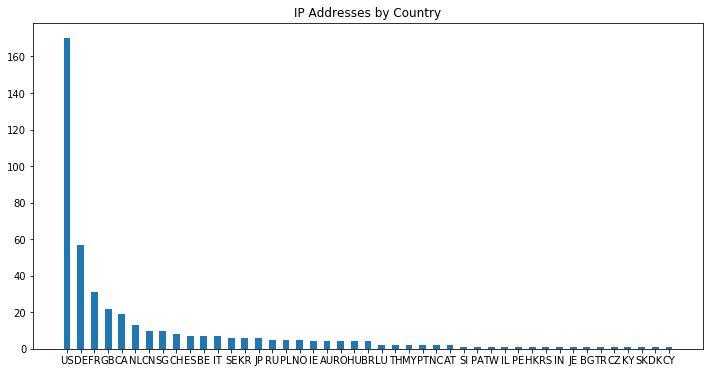

In [20]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

countries=[]
for ip,info in saved_ips_info.items():
    if info['country_name'] != None:
        countries.append(info['country'])


counts = Counter(countries)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(12,6))
plt.title('IP Addresses by Country')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

In [21]:
subnets = df["subnet_ids"].to_list()
subnets = [subnet.replace('[','').replace(']','').replace(' ','') for subnet in subnets]
subnets = [subnet if len(subnet) > 0 else 'None' for subnet in subnets]
subnets = ','.join(subnets)
subnets = subnets.split(',')
labels = [str(label) for label in list(range(0,64))] + ['None']
values = [subnets.count(label) for label in labels]

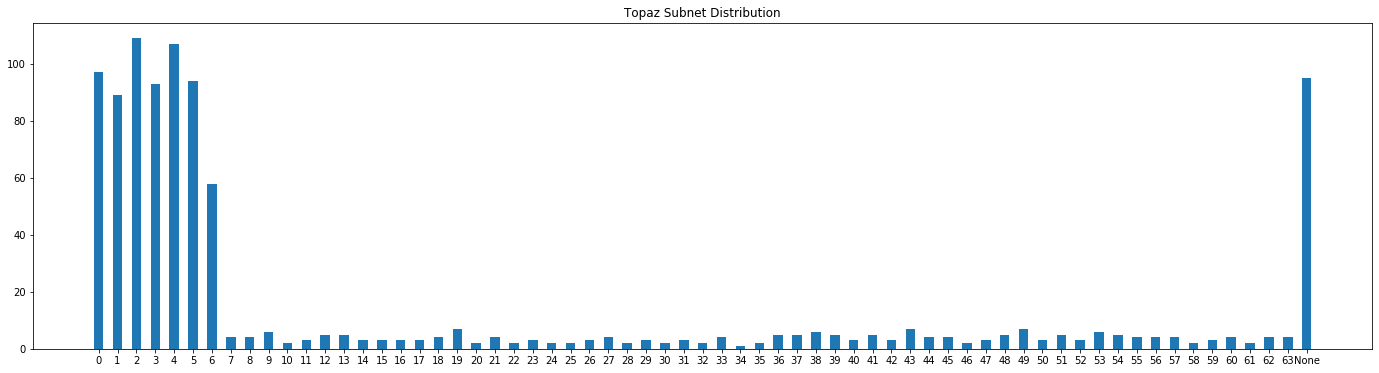

In [22]:
import numpy as np
import matplotlib.pyplot as plt

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(24,6))
plt.title('Topaz Subnet Distribution')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()